# Imaging Sky Background Estimation


**Use case:** estimate the sky background in complex scenes and evaluate the quality of the sky estimation.<br>
**Data:** images with pathological background pattern created in the notebook.<br>
**Tools:** photutils.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

Sky estimation is one of the tricker aspects of image processing. This is in part because the "sky" is part of the astronomical scene. Some of what is considered background may be in the foreground (thermal background in the detector, scattered light, or zodiacal light). Sometimes the objects of interest overlap (galaxies in front of other galaxies). This notebook does not address the "de-blending" problem of overlapping galaxies, but does outline some of the techniques for dealing with large-scale patterns in the sky. 

The Photutils manual has an extensive discussion of [background estimation](https://photutils.readthedocs.io/en/stable/background.html), which is the basis for much of what is in this notebook.

## Imports

 * Numpy for general array computations
 * Scipy for some stats operations and interpolation
 * Photutils for photometry calculations
 * Astropy table for viewing the parameters of the sky-background blemishes
 * Astropy convolution for smoothing the image 
 * Routines from photutils for background subtraction and masking
 * Astropy tables for manipulating a list of sources (galaxies) injected into the image
 * Astropy convolution for dilating the sky image and source mask
 * Astropy modeling for fitting a line to the residuals of the background subtraction
 * Astropy block_reduce for looking at the RMS of the residuals as a function of scale (blocking factor)

In [1]:
# For style checking
# %load_ext pycodestyle_magic
# %flake8_on

In [2]:
import numpy as np
from scipy import stats, ndimage, interpolate
from astropy import stats as astrostats
from photutils import (
    datasets,  # For making simulated data
    Background2D,  # For estimating the background
    MedianBackground, BiweightLocationBackground, SExtractorBackground,
    BkgIDWInterpolator, BkgZoomInterpolator,  # For interpolating background
    make_source_mask)
from photutils.utils import ShepardIDWInterpolator as idw
from astropy.table import Table
from astropy.convolution import (
    convolve, Box2DKernel, Tophat2DKernel,
    Ring2DKernel, Gaussian2DKernel)
from scipy.ndimage.filters import median_filter
from astropy.modeling import models, fitting
from astropy.nddata.blocks import block_reduce
from astropy.nddata import NDData
from IPython.display import HTML
from jdaviz import Imviz

## Matplotlib setup for plotting

There are two versions
  * notebook -- gives interactive plots, but makes the overall notebook a bit harder to scroll
  * inline -- gives non-interactive plots for better overall scrolling

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version if you want interactive plots
# %matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
np.random.seed(seed=4)  # For repeatability

## Create an image with a somewhat pathological background pattern

This image has a pixel-to-pixel RMS of 0.1, and the background non-uniformities we add are of comparable level to the pixel-to-pixel noise. So you can't get rid of the non-uniformities without doing a fair amount of smoothing. We'll add:
 * A background gradient
 * A few sinc-function blemishes scattered around the image. Make the period of the sinc function large enough that these blemishes shouldn't look much like sources (assumed to be only a few pixels to tens of pixels across).
 
This particular test case was deviously chosen to be one where just adding higher orders to (say) a Chebyshev polynomial surface fit is likely to do a poor job. Similarly, increasing the order of a bicubic spline is not likely to be satisfactory.

### Set up grid and the random number seed for the simulation

The test is best illustrated with a 2000x2000 image, but `shrink_factor` can be used to make the notebook run fast for testing. The random number seed is set to allow for repeatability. 

In [5]:
default_size = 2000
shrink_factor = 2  # To make the images smaller for faster execution
nrow = ncol = default_size // shrink_factor  # Image size
row, col = np.mgrid[0:nrow, 0:ncol]

### Create the nasty sky background

Blemishes are inserted as sinc-functions with random centers and widths and amplitudes. 

In [6]:
nblemish = 16//shrink_factor  # Number of sinc-function blemishes to add
row_centers = ncol*np.random.random_sample(size=nblemish)
col_centers = nrow*np.random.random_sample(size=nblemish)
# Make the wavelength of sinc ripples pretty large
width = 30+100.*np.random.random_sample(size=nblemish)
amplitude = 1.*np.random.random_sample(size=nblemish)
noiseless_sky = np.zeros((nrow, ncol), dtype=np.float32)
for rr, cc, w, a in zip(row_centers, col_centers, width, amplitude):
    r = np.sqrt((row-rr)**2 + (col-cc)**2)
    noiseless_sky = noiseless_sky + a*np.sinc(r/(w*np.pi))
blemishes = Table([col_centers, row_centers, width, amplitude],
                  names=['x', 'y', 'width', 'amplitude'])
blemishes

x,y,width,amplitude
float64,float64,float64,float64
252.98236238344396,967.0298390136767,30.8986097667555,0.17316542149594816
434.7915324044458,547.2322491757224,68.65712826436294,0.07494858701310703
779.3829217937524,972.6843599648844,34.41600579314996,0.6007427213777693
197.68507460025307,714.8159936743647,125.66529677142358,0.16797218371840383
862.9932355992222,697.7288245972708,73.61466468797977,0.7333801675105699
983.4006771753128,216.08949558037637,124.89773067815628,0.4084438601520147
163.8422414046987,976.2744547762418,108.6305985935061,0.5279088234179203
597.3339439328593,6.230255204589863,116.62892985816984,0.937571583950942


Add a gradient on top of the blemishes

In [7]:
gradient = (1.*row)/nrow+(0.25*col)/ncol
noiseless_sky += gradient
noise = np.random.normal(scale=0.1, size=np.shape(noiseless_sky))
sky_bkgd = noiseless_sky + noise
mean_bkgd = sky_bkgd.mean()

Text(0.5, 1.0, 'The noiseless sky background')

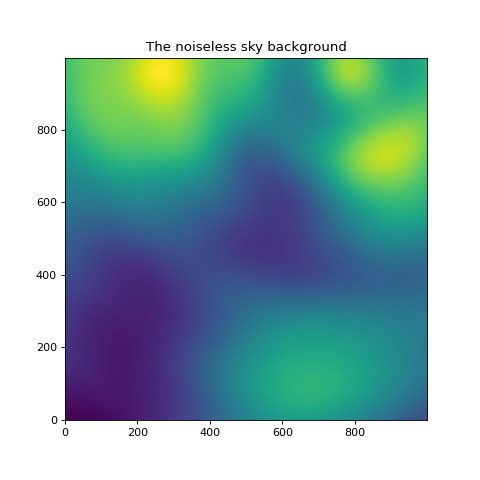

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(noiseless_sky,origin='lower')
plt.title('The noiseless sky background')

Alternatively, try opening the image in Imviz, the new interactive image viewing tool. For more information on Imviz, please visit this link. https://jdaviz.readthedocs.io/en/latest/imviz/index.html

In [9]:
imviz = Imviz()
viewer = imviz.default_viewer

In [10]:
imviz.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [11]:
imviz.load_data(noiseless_sky, data_label='noiseless_sky_background')

Consider some example API commands you can run from the notebook, although many of the manipulation can be done within Imviz.

In [12]:
viewer.stretch_options
viewer.stretch = 'sqrt'

In [13]:
viewer.colormap_options
viewer.set_colormap('viridis')

### Look at it with noise added and then smoothed a bit
Smooth with a 10x10 boxcar kernel

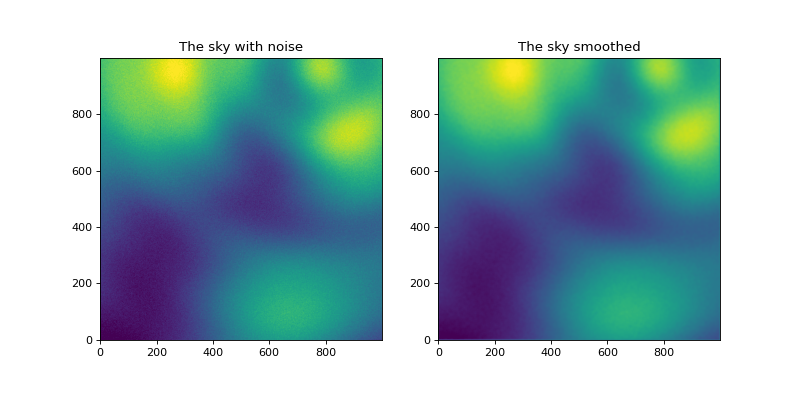

In [14]:
sky_smoothed = convolve(sky_bkgd-mean_bkgd, Box2DKernel(10))
zmin, zmax = np.percentile(sky_smoothed, (0.1, 99.9))
plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax1.imshow(sky_bkgd-mean_bkgd, vmin=zmin, vmax=zmax,origin='lower')
ax1.set_title('The sky with noise')
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
ax2.set_title('The sky smoothed')
ax2.imshow(sky_smoothed, vmin=zmin, vmax=zmax,origin='lower')

Do the same thing in Imviz and compare images side-by-side, locking by pixels.

In [15]:
imviz2 = Imviz()
viewer = imviz2.default_viewer

In [16]:
imviz2.app

Application(config='imviz', events=['call_viewer_method', 'close_snackbar_message', 'data_item_selected', 'des…

In [17]:
imviz2.load_data(sky_bkgd-mean_bkgd, data_label='sky_with_noise')
viewer.stretch_options
viewer.stretch = 'sqrt'
viewer.colormap_options
viewer.set_colormap('viridis')

In [18]:
imviz2.load_data(sky_smoothed, data_label='sky_smoothed')
viewer2_name = 'viewer2'
viewer2 = imviz2.create_image_viewer(viewer_name=viewer2_name)

In [19]:
imviz2.app.add_data_to_viewer(viewer2_name,'sky_smoothed')
viewer2.stretch_options
viewer2.stretch = 'sqrt'
viewer2.colormap_options
viewer2.set_colormap('viridis')

# Video1:

Link two images in different windows by pixel and manipulate image.

In [20]:
# Video showing how to link two images in pixel space using plugin
HTML('<iframe width="700" height="500" src="https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/Background_Estimation/imviz_demo_1.mov" frameborder="0" allowfullscreen></iframe>')

/Users/ofox/miniconda3/envs/aas239-jwebbinar3/lib/python3.8/site-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Add some random sources

We'll create a catalog of sources that have elliptical Gaussian profiles with a variety of fluxes, sizes, and position angles. The sizes are kept relatively small relative to the structure in the background. Store these sources in an Astropy table for convenience. 

In [ ]:
sources = Table()
nsources = 5000//(shrink_factor**2)
rand_sample = np.random.random_sample  # Save typing
random_sample = rand_sample(nsources)
sources['x_mean'] = 2.+(ncol-4.)*rand_sample(nsources)  # avoid the edges
sources['y_mean'] = 2.+(nrow-4.)*rand_sample(nsources)
sources['flux'] = 50*rand_sample(nsources)
sources['x_stddev'] = 5.*rand_sample(nsources)
sources['y_stddev'] = 5.*rand_sample(nsources)
sources['re'] = np.sqrt(sources['x_stddev']*sources['y_stddev'])
sources['theta'] = 180.*rand_sample(nsources)*np.pi / 180.

Add these sources to the image to create a scene.

In [ ]:
source_img = datasets.make_gaussian_sources_image(sky_bkgd.shape, sources)
scene = source_img + sky_bkgd

In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(scene-mean_bkgd, vmin=zmin, vmax=zmax, origin='lower')
plt.title('The scene, with the sources and nasty sky background')

### Routine for making a plot to compare two images side by side

In [ ]:
def plot_two(img1, img2, vmin, vmax, figsize=(10, 6), titles=['', ''],
             cmap=plt.cm.viridis):
    ax1 = plt.figure(figsize=figsize)
    ax1 = plt.subplot(121)
    ax1.imshow(img1, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    ax1.set_title(titles[0])
    ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
    ax2.imshow(img2, vmin=vmin, vmax=vmax, cmap=cmap, origin='lower')
    ax2.set_title(titles[1])

## Try using Photutils Background2D mesh grid as a  first attempt

Now we need to make a first-cut estimate of the background. Photutils provides a flexible interface to estimating the background in a mesh of cells. We use the `Background2D` routine here, with a fairly typical set of parameters. See the [documentation](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D) 
for more information. 

This tasks creates a mesh of rectangular cells covering the image. The unmasked pixels within each cell are "averaged" using a configurable robust statistic. These averages can then be "averaged" on some larger scale using a configurable robust statistic. This filtered set of averages is then used to feed an interpolation routine to make a smooth background. The default interpolation is a bicubic spline, but we will illustrate inverse-distance weighting interpolation later on in the notebook.

Try adjusting the arguments to Background2D to see the effect. 
 * The second argument (50 below) is the mesh grid size. This can also be a rectangle -- e.g. (50,40) --  if desired.
 * `sigma_clip` is the method to use for robust averaging within the grid cells.
 * `filter_size` is how many cells to "averaged" before doing the interpolation. This can also be a rectangle -- e.g. (3,4) -- if desired.  
 * `bkg_estimator` is the method to use for averaging the values in the cells.
 * `exclude_percentile`  If a mesh has more than this percent of its pixels masked then it will be excluded from the low-resolution map. 
 * `interpolator` is the method to use to interpolate the background (bicubic spline in this case)

In [ ]:
bkg = Background2D(scene, box_size=50,
                   sigma_clip=astrostats.SigmaClip(sigma=3.),
                   filter_size=3,
                   exclude_percentile=50,
                   bkg_estimator=MedianBackground(),
                   interpolator=BkgZoomInterpolator(order=3))
plt.figure(figsize=(6, 6))
plt.imshow(bkg.background-noiseless_sky, vmin=0.1*zmin, vmax=0.1*zmax, origin='lower');

Make a couple masks. The `make_source_mask` routine has a few options. Try changing them to see what they do. The aim here is to find and mask sources without seeing an appreciable enhancement of sources in regions where the background  is high. There are several parameters that can be adjusted:
 * `nsigma` -- we will try this with 2 and 3 sigma cuts
 * `npixels` -- the number of connected pixels above the threshold required before masking
 * `dilate_size` -- the size of a square box-car filter used to grow the mask
 * `filter_fwhm` -- the image is convolved with a Gaussian of this FWHM before thresholding. 

In [ ]:
mask_2sigma = make_source_mask(scene-bkg.background, nsigma=2, npixels=3,
                               dilate_size=5, filter_fwhm=3)
mask_3sigma = make_source_mask(scene-bkg.background, nsigma=3, npixels=3,
                               dilate_size=5, filter_fwhm=3)
plot_two(mask_2sigma, mask_3sigma, 0, 1)

Try reducing the mesh size of the background estimation in the `Background2D` task. The smaller mesh size definitely helps, but there is a hint in the residual image on the right that sources are biasing the background estimate. 

In [ ]:
sigma_clip = astrostats.SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg1 = Background2D(scene, (30, 30), filter_size=(3, 3), mask=mask_3sigma,
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
bkg2 = Background2D(scene, (15, 15), filter_size=(3, 3), mask=mask_3sigma,
                    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
plot_two(bkg1.background-noiseless_sky, bkg2.background-noiseless_sky,
         0.1*zmin, 0.1*zmax, titles=['bkg1', 'bkg2'])

## Ring median filtering the image

It's clear we are going to do more iteration to do the source removal. Before doing that, let's try another approach to removing the sources: the ring-median filter. To do this, create a filter kernel that is larger than the sources of interest. Use the scipy median-filtering routine to slide this across the image, taking the median of all the pixels within the ring. This basically gives a local-background estimate for each pixel. 
(While we don't illustrate it here, it's possible to use [`scipy.ndimage.generic_filter`](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.ndimage.filters.generic_filter.html) and pass it a function to compute something other than a median.)

The cell below sets up the kernel.

In [ ]:
ring = Ring2DKernel(15, 5)
plt.imshow(ring.array)

Compare the scene (minus the mean background) to the filtered scene.

In [ ]:
filtered = median_filter(scene, footprint=ring.array)
plot_two(scene-mean_bkgd, filtered-mean_bkgd, zmin, zmax,
         titles=['Sources', 'ring-median filtered'])

Subtract the ring-median filtered image from the scene as the first cut at background subtraction. Convolve this with a kernel to smooth for source detection, and threshold that to identify pixels that are part of sources.

In [ ]:
difference = scene-filtered
smoothed = convolve(difference, Gaussian2DKernel(3))
mask = smoothed > 1.*smoothed.std()
plot_two(difference, mask, zmin, zmax,
         titles=['scene minus ring-median filtered scene', 'mask'])

It's often useful to grow the mask. This can be accomplished by convolving with a filter. Here, we adopt a circular tophat filter.

In [ ]:
def dilate_mask(mask, tophat_size):
    ''' Take a mask and make the masked regions bigger.'''
    area = np.pi*tophat_size**2.
    kernel = Tophat2DKernel(tophat_size)
    dilated_mask = convolve(mask, kernel) >= 1./area
    return dilated_mask

In [ ]:
dilated_mask = dilate_mask(mask, 2)
plot_two(mask, dilated_mask, 0, 1, titles=['mask', 'dilated mask'])

Mask the image and see how many sources are still remaining

In [ ]:
plot_two(scene-noiseless_sky, (scene-noiseless_sky)*(1.-mask), zmin, zmax,
         titles=['scene without background', 'masked scene without background'])

Let's make a fancier plot that shows background residuals, the residuals with the sources and source mask overlayed, and the background-subtracted scene. 

In [ ]:
def plot_bkgd(scene, mask, bkgd, noiseless_bkgd, sources,
              zmin, zmax, factor=0.1,  # Control the colormap stretch
              figsize=(20, 10)):
    '''Make a three-panel plot of:
         * the residual sky background
         * the residual sky background times the mask with
           masked sources overlayed as '+' signs and
           unmasked sources overlayed as circles, and
         * The background-subtracted scene.
    '''
    residual = bkgd-noiseless_bkgd
    plt.figure(figsize=figsize)
    # Plot the background residual
    ax1 = plt.subplot(131)
    ax1.imshow(residual, vmin=factor*zmin, vmax=factor*zmax, origin='lower')
    ax1.set_title('residual sky background')
    ax2 = plt.subplot(132, sharex=ax1, sharey=ax1)
    ax2.imshow(residual*(1-mask), vmin=factor*zmin, vmax=factor*zmax,
               origin='lower')
    xs = np.rint(sources['x_mean']).astype(np.int32)
    ys = np.rint(sources['y_mean']).astype(np.int32)
    masked = mask[ys, xs]
    unmasked = np.invert(masked)
    ax2.scatter(xs[masked], ys[masked], s=sources['flux'][masked], marker='+',
                c='red', alpha=0.2)
    ax2.scatter(xs[unmasked], ys[unmasked], s=sources['flux'][unmasked],
                c='black', alpha=0.5)
    ax2.set_xlim(0, scene.shape[1])
    ax2.set_ylim(0, scene.shape[0])
    ax2.set_title('with masked + unmasked O sources')
    ax3 = plt.subplot(133, sharex=ax1, sharey=ax1)
    ax3.imshow(scene-bkgd, vmin=zmin, vmax=zmax, origin='lower')
    ax3.set_title('Scene minus estimated background')
    print(f"Residual RMS, peak = {residual.std():.4f}, {residual.max():.4f}")

Try this fancier plot. The default scaling of the first two plots has a harder stretch in the colormap, so we can now see that there are ring-shaped residuals around all the bright sources. These are not readily apparent in the third plot, which has the stretch we used for the earlier plots.

In [ ]:
plot_bkgd(scene, mask, filtered, noiseless_sky, sources, zmin, zmax)

## Set up some routines for convenience in iterating the mask

Next we will try iterating in fitting the background and progressively removing sources at lower and lower S/N. We'll want to inspect at each step. Here are some functions to reduce typing:

  * `SourceMask` -- This is an class to set up some parameters for the masking and give us a couple methods:
     * `single` -- appy an existing mask and then use photutils make_source_mask to make a new one; convolve the mask with a circular tophat kernel and threshold to dilate it
     * `multiple` -- repeatedly apply the `single` method to make a new mask. OR that with the previous masks.
  * `find_worst_residual_near_center` -- when plotting a zoomed in image for inspection, we'd like to select the section away from the edges that has the worst residuals
  * `plot_mask` -- plots the mask for the whole image and plots it as contours overlayed on a small subsection

In [ ]:
def my_background(img, box_size, mask, interp=None, filter_size=1,
                  exclude_percentile=90):
    ''' Run photutils background with SigmaClip and MedianBackground'''
    if interp is None:
        interp = BkgZoomInterpolator()
    return Background2D(img, box_size,
                        sigma_clip=astrostats.SigmaClip(sigma=3.),
                        filter_size=filter_size,
                        bkg_estimator=MedianBackground(),
                        exclude_percentile=exclude_percentile,
                        mask=mask,
                        interpolator=interp)

In [ ]:
class SourceMask:
    def __init__(self, img, nsigma=3., npixels=3):
        ''' Helper for making & dilating a source mask.
             See Photutils docs for make_source_mask.'''
        self.img = img
        self.nsigma = nsigma
        self.npixels = npixels

    def single(self, filter_fwhm=3., tophat_size=5., mask=None):
        '''Mask on a single scale'''
        if mask is None:
            image = self.img
        else:
            image = self.img*(1-mask)
        mask = make_source_mask(image, nsigma=self.nsigma,
                                npixels=self.npixels,
                                dilate_size=1, filter_fwhm=filter_fwhm)
        return dilate_mask(mask, tophat_size)

    def multiple(self, filter_fwhm=[3.], tophat_size=[3.], mask=None):
        '''Mask repeatedly on different scales'''
        if mask is None:
            self.mask = np.zeros(self.img.shape, dtype=np.bool)
        for fwhm, tophat in zip(filter_fwhm, tophat_size):
            smask = self.single(filter_fwhm=fwhm, tophat_size=tophat)
            self.mask = self.mask | smask  # Or the masks at each iteration
        return self.mask

In [ ]:
def find_worst_residual_near_center(resid):
    '''Find the pixel location of the worst residual, avoiding the edges'''
    yc, xc = resid.shape[0]/2., resid.shape[1]/2.
    radius = resid.shape[0]/3.
    y, x = np.mgrid[0:resid.shape[0], 0:resid.shape[1]]
    mask = np.sqrt((y-yc)**2+(x-xc)**2) < radius
    rmasked = resid*mask
    return np.unravel_index(np.argmax(rmasked), resid.shape)

In [ ]:
def plot_mask(scene, bkgd, mask, zmin, zmax, worst=None, smooth=0):
    '''Make a three-panel plot of:
         * the mask for the whole image,
         * the scene times the mask
         * a zoomed-in region, with the mask shown as contours
    '''
    if worst is None:
        y, x = find_worst_residual_near_center(bkgd-noiseless_sky)
    else:
        x, y = worst
    plt.figure(figsize=(20, 10))
    plt.subplot(131)
    plt.imshow(mask, vmin=0, vmax=1, cmap=plt.cm.gray, origin='lower')
    plt.subplot(132)
    if smooth == 0:
        plt.imshow((scene-bkgd)*(1-mask), vmin=zmin, vmax=zmax, origin='lower')
    else:
        smoothed = convolve((scene-bkgd)*(1-mask), Gaussian2DKernel(smooth))
        plt.imshow(smoothed*(1-mask), vmin=zmin/smooth, vmax=zmax/smooth,
                   origin='lower')
    plt.subplot(133)
    plt.imshow(scene-bkgd, vmin=zmin, vmax=zmax)
    plt.contour(mask, colors='red', alpha=0.2)
    plt.ylim(y-100, y+100)
    plt.xlim(x-100, x+100)
    return x, y

## Estimate the background on a finer scale after masking sources

In [ ]:
bkg3 = my_background(scene, box_size=10, filter_size=5, mask=mask)
plot_bkgd(scene, mask, bkg1.background, noiseless_sky, sources, zmin, zmax)

### Try a different interpolation algorithm.
The Shephard inverse-distance weighting searches for 
the N grid points nearest to the pixel of interest and weights them as $1/(D^p + \lambda)$ 
where $D$ is the distance to the neighbor, $p$ is a power, and $\lambda$ is a parameter to 
make the weighting of the neighbors smoother closer to the pixel of interest. 

In [ ]:
interpolator = BkgIDWInterpolator(n_neighbors=20, power=1, reg=30)
bkg4 = my_background(scene, box_size=10, filter_size=5, mask=mask,
                     interp=interpolator, exclude_percentile=90)
plot_bkgd(scene, mask, bkg4.background, noiseless_sky, sources, zmin, zmax)

### Make a deeper source mask. 
This runs three iterations, with different kernel widths and different tophat sizes for growing the mask. Try varying `sigma`, `filter_fwhm` and `tophat_size` to see how they affect the sources. The aim is to mask sources that are easily visible, but leave plenty of pixels for tracing the background.

In [ ]:
sm = SourceMask(scene-bkg4.background, nsigma=1.5)
mask = sm.multiple(filter_fwhm=[1, 3, 5],
                   tophat_size=[4, 2, 1])
plot_mask(scene, bkg4.background, mask, zmin, zmax)
mask.sum()

### Redo the background estimation using this new mask. 
Play with `n_neighbors`, `box_size`, `filter_size` and `exclude_percentile` to see how they affect the residuals.

In [ ]:
interpolator = BkgIDWInterpolator(n_neighbors=20, power=0, reg=30)
bkg5 = my_background(scene, box_size=6, filter_size=3, mask=mask,
                     interp=interpolator, exclude_percentile=90)
plot_bkgd(scene, mask, bkg5.background, noiseless_sky, sources, zmin, zmax)

## Check for bias in due to the galaxies

Since we are dealing with a simulation, where we know truth, we can evaluate the biases directly. (In the case of a real image, we can't do that; we'll suggest another test further down). 

Tabulate the residual background under the central 3x3 pixels under each galaxy vs the flux of the galaxy, separately for those that are masked and those that are unmasked. First we need to get these values. Take the mean for  3x3 pixels centered on each source. Keep track of the ones that were masked in fitting the background and the ones that weren't so we can check separately for any bias.

In [ ]:
bkgd = bkg5.background
residual_image = bkgd-noiseless_sky

# Create columns in the table for the background estimate, the residual,
# and a flag for whether or not this source was masked
sources['bkgd'] = 0.*sources['flux']
sources['resid'] = 0.*sources['flux']
sources['masked'] = np.zeros(len(sources), dtype=np.bool)

# Compute the values for the 3x3 pixels centered on each source
for i in range(len(sources)):
    s = sources[i]
    x = np.rint(s['x_mean']).astype(np.int32)
    y = np.rint(s['y_mean']).astype(np.int32)
    xmin, xmax = max(0, x-1), min(ncol, x+1)
    ymin, ymax = max(0, y-1), min(nrow, y+1)
    sources['resid'][i] = residual_image[ymin:ymax, xmin:xmax].mean()
    sources['bkgd'][i] = bkgd[ymin:ymax, xmin:xmax].mean()
    sources['masked'][i] = mask[y, x]  # Flag only if central pixel was masked

Make a list of random positions and do the same measurement, as a control. 

In [ ]:
# Set up the arrays for the random positions
N_random = 5*len(sources)
resid_under_random = np.zeros(N_random, dtype=np.float64)
bkgd_under_random = np.zeros(N_random, dtype=np.float64)
masked_random = np.zeros(N_random, dtype=np.bool)

# Grab a random flux and radius from the catalog, just so we can plot
# The results for the random sources on the same axis as the real sources
random_flux = sources['flux'][np.random.randint(0, len(sources), N_random)]
random_re = sources['re'][np.random.randint(0, len(sources), N_random)]
rnd_x = np.random.randint(2, ncol-2, size=N_random)
rnd_y = np.random.randint(2, nrow-2, size=N_random)

# Compute the values for the 3x3 pixels centered on each source
for i, x, y in zip(range(len(rnd_x)), rnd_x, rnd_y):
    resid_under_random[i] = residual_image[y-1:y+1, x-1:x+1].mean()
    bkgd_under_random[i] = bkgd[y-1:y+1, x-1:x+1].mean()
    masked_random[i] = mask[y-1:y+1, x-1:x+1].min().astype(np.bool)

# Only keep the results for locations that weren't masked
resid_under_random = resid_under_random[~masked_random]
random_flux = random_flux[~masked_random]
random_re = random_re[~masked_random]
print(f"Nsources, Nrandom: {len(sources)} {len(resid_under_random)}")

Make lists of the masked and unmasked sources

In [ ]:
flux = sources['flux']
resid = sources['resid']
re = sources['re']
masked = sources['masked']
unmasked = np.invert(sources['masked'])

Define a function `fit_line` to fit a line to the data points, and another function `fit_and_plot` to plot the data points and the best-fit line together.

In [ ]:
def fit_line(x, y):
    line = models.Linear1D(1., 1.)
    fit = fitting.LinearLSQFitter()
    best_fit = fit(line, x, y)
    return best_fit

In [ ]:
def fit_and_plot(x, y, alpha=0.2, color='red', s=10,
                 marker='o', label=''):
    xfit = np.linspace(0, x.max(), 10)
    line = fit_line(x, y)
    plt.scatter(x, y, alpha=alpha, color=color, s=s, marker=marker,
                label=label)
    plt.plot(xfit, line(xfit), color=color, alpha=0.7)

Plot the residuals vs. source flux, separately for the masked, unmasked, and randomized source positions. Make the sizes of the markers proportional to the fluxes of the sources. Ideally, this should be centered at 0.0 for all three cases, with no correlation with source flux. Of course, it is nearly impossible not to have a bias where the sources were not masked, since they then contribute to the background estimate. In this particular case, there is a small offset in the residuals when the source was not masked, and evidence of a trend with the flux of the source.

In [ ]:
plt.figure(figsize=(10, 5))
fit_and_plot(flux[unmasked], resid[unmasked], s=10.*re[unmasked],
             label='unmasked', color='black', alpha=0.5, marker='s')
fit_and_plot(flux[masked], resid[masked], s=10.*re[masked],
             label='masked', color='red', alpha=0.3, marker='o')
fit_and_plot(random_flux, resid_under_random, color='blue', alpha=0.1,
             marker='+', label='random')
plt.legend()
plt.ylim(-0.05, 0.05)
plt.title('residuals vs. flux');

In [ ]:
plt.figure(figsize=(10, 6))
fit_and_plot(re[unmasked], resid[unmasked], s=2*flux[unmasked],
             label='unmasked', color='black', alpha=0.5, marker='s')
fit_and_plot(re[masked], resid[masked], s=flux[masked],
             label='masked', color='red', alpha=0.2, marker='o')
fit_and_plot(random_re, resid_under_random, color='blue', alpha=0.1,
             marker='+', label='random')
plt.legend()
plt.ylim(-0.05, 0.05)
plt.title('residuals vs. radius');

### Testing for bias on real data
With real data, we can't take the residual relative to noiseless sky. However, we can check for evidence that the background under the masked areas is statistically higher than the background in the random areas. Given that astronomical sources have wings and these can't be subtracted without modeling them, it is very hard to achieve perfection here. This test will tell you the magnitude of the potential bias (in flux per pixel) and whether or not it looks significant.

In [ ]:
mean_masked = bkgd[mask].mean()
std_masked = bkgd[mask].std()
stderr_masked = mean_masked/(np.sqrt(len(bkgd[mask]))*std_masked)

mean_unmasked = bkgd[~mask].mean()
std_unmasked = bkgd[~mask].std()
stderr_unmasked = mean_unmasked/(np.sqrt(len(bkgd[~mask]))*std_unmasked)

diff = mean_masked - mean_unmasked
significance = diff/np.sqrt(stderr_masked**2 + stderr_unmasked**2)

print(f"Mean under masked pixels   = {mean_masked:.4f} +- {stderr_masked:.4f}")
print(f"Mean under unmasked pixels = "
      f"{mean_unmasked:.4f} +- {stderr_unmasked:.4f}")
print(f"Difference = {diff:.4f} at {significance:.2f} sigma significance")

## Routines to facilitate looking at the RMS of the residual background as a function of scale
One way to evaluate whether the sky-subtraction looks sensible is to see whether the RMS is dropping sensibly as a
function of scale. It should drop linearly with the area size of the image sampled. 

To do this test, we would like to look at unmasked regions, but have them all have the same S/N. So we need a way to set up a mesh grid that has no masked pixels in each of the mesh areas.


In [ ]:
def smoothsample_masked(img, mask, width=9):
    '''Take the means in squares that have no masked pixels'''
    nrow, ncol = img.shape
    w = width/2
    # Mask out the borders
    row, col = np.mgrid[0:nrow, 0:ncol]
    mask = mask | (row < w) | (row > nrow-w) | (col < w) | (col > ncol-w)
    # Make a list of the squares that contain no masked pixels
    mm = block_reduce(mask, width)
    means = block_reduce(img, width, func=np.mean)
    good = np.where(mm == 0)
    return means[good]


def calculate_stats(residual, mask, widths):
    stats = []
    for w in widths:
        val = smoothsample_masked(residual, mask, w)
        stats += [val.std()]
    return np.array(stats)

Calculate the statistics for the different background estimates. These are the residuals of the masked "scene" -- i.e. with the sources in it, but masked as well as one might do for a real scene. These are to be compared to the "perfect" case of the noisy sky background minus the noiseless sky background, where the statistics are computed in the same unmasked cells.

In [ ]:
rms = Table()
widths = rms['widths'] = np.arange(3, 30, 1)
rms['bkg1'] = calculate_stats(scene-bkg1.background, mask, widths)
rms['bkg2'] = calculate_stats(scene-bkg2.background, mask, widths)
rms['bkg3'] = calculate_stats(scene-bkg3.background, mask, widths)
rms['bkg4'] = calculate_stats(scene-bkg4.background, mask, widths)
rms['bkg5'] = calculate_stats(scene-bkg5.background, mask, widths)
rms['perfect'] = calculate_stats(sky_bkgd-noiseless_sky, mask, widths)

Plot the results relative to the perfect case (we've commented out the initial `bkg1` estimate just to make the scale more visible for the better estimates). It is worth noting that the `bkg1` is typical of what one might get from SExtractor, which offers only a single pass for the background estimation.

In [ ]:
plt.figure(figsize=(10, 6))
perfect = rms['perfect']
# plt.plot(rms['widths'],rms['bkg1']/perfect,alpha=0.5,label='bkg1')
plt.plot(rms['widths'], rms['bkg2']/perfect, alpha=0.5, label='bkg2')
plt.plot(rms['widths'], rms['bkg3']/perfect, alpha=0.5, label='bkg3')
plt.plot(rms['widths'], rms['bkg4']/perfect, alpha=0.5, label='bkg4')
plt.plot(rms['widths'], rms['bkg5']/perfect, alpha=0.5, label='bkg5')
plt.plot(rms['widths'], rms['perfect']/perfect, 'k-', alpha=1, label='perfect')
plt.legend();

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>